# Approach 2: Edge skimming

In [1]:
import re
import urllib.request
import openpyxl
import requests
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random
from networkx.algorithms.community.centrality import girvan_newman
from cdlib import algorithms, viz

In [2]:
main_url = "https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/"

def parseForDownloadUrls():
    links = []
    resp = requests.get(main_url)
    page_str = str(resp.content)

    for word in page_str.split():
        # print(word)
        s = str(word)
        pattern = 'href=".*xlsx'
        mat = re.search(pattern, s)
        if mat:
            links.append(main_url+mat.group().split('"')[1])
    return links

def downloadUrls(link):

    out_filename = link.split('/')[-1].split('.')[0].replace("%20", " ")+'.csv'
    if os.path.isfile(out_filename):
        print('file exsists', out_filename)
    else:
        df = pd.read_excel(link)
        df.drop(df.index[:8], inplace=True)
        df = df.iloc[:,1:5]
        df = df.reset_index(drop = True)
        df.index += 1
        df.to_csv(out_filename)
        print('downloaded', out_filename)
    return out_filename

In [3]:

download_urls = parseForDownloadUrls()
print("These are the obtained links:-")
for i in range(len(download_urls)):
    print(i+1,"-",download_urls[i])

downloaded_files = []

for url in download_urls:
    try:
        filename = downloadUrls(url)
        downloaded_files.append(filename)

    except:
        print('cannot download', url)

These are the obtained links:-
1 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2002%20Computer%20Organization%20and%20Architecture.xlsx
2 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2003%20Database%20Management%20Systems.xlsx
3 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2004%20Introduction%20to%20Data%20Science.xlsx
4 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3009-Network%20Security%20&amp;%20Cryptography.xlsx
5 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3010-Software%20Engineering.xlsx
6 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3011-Artificial%20Intelligence.xlsx
7 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS8004-Deep%20Learning%20and%20Applications.xlsx
8 

In [4]:
print(len(downloaded_files))

131


In [5]:
# student_data = {'roll': {'name':, 'branch':, 'courses': [], 'email': }}
student_data = {}
for filename in downloaded_files:
  try:
    df = pd.read_csv(filename)
  except:
    print('cannt open file', filename)
  course_name = filename.split('.')[0]
  for ind in df.index:
    roll = str(df['Unnamed: 1'][ind]).strip()
    if roll in student_data:
      student_data[roll]['courses'].append(course_name)
    else:
      student_data[roll] = {'name': str(df['Unnamed: 2'][ind]), 'branch': str(df['Unnamed: 3'][ind]), 'courses': [course_name]}


In [6]:
print(len(student_data))

1498


In [7]:
import networkx as nx
import matplotlib.pyplot as plt


In [8]:
G = nx.Graph()
for k in list(student_data.keys()):
  G.add_node(str(k))

edges = {}

for n1 in G.nodes():
  for n2 in G.nodes():
    if n1 >= n2:
      continue
    for course in student_data[n1]['courses']:
      if course in student_data[n2]['courses']:
        # G.add_edge(n1, n2, weight)
        if (n1, n2) in edges:
          edges[(n1, n2)] += 1
        else:
          edges[(n1, n2)] = 1
for e in edges.keys():
    G.add_edge(e[0], e[1], weight = edges[e])

In [ ]:
d = {}
for x in edges.keys():
    if edges[x] in d:
        d[edges[x]] += 1
    else:
        d[edges[x]] = 1
print(d)



## Skimming using IoU

- To reduce the number of edges we can skim edges with less weight.
- Instead of regular skimming we can use IoU approach (Intersection over Union)

In [10]:
G0 = nx.Graph()
G0.add_nodes_from(G.nodes())


# Set similarity threshold. more similarity threshold indicates lessnumber of edges

similarity_threshold = 0.6

for e in G.edges():
    
    # Calculate Union
    total_courses = len(set(student_data[e[0]]['courses'] + student_data[e[1]]['courses']))
    
    # Calculate intersection
    common_courses = len(set(student_data[e[0]]['courses']).intersection(student_data[e[1]]['courses']))
    
    # IoU
    similarity_score = common_courses/total_courses
    if similarity_score > similarity_threshold:
        G0.add_edge(e[0], e[1])
        
# Updated reduced number of edges
print(G0.number_of_nodes(), G0.number_of_edges())

1498 88986


no of connected components 45


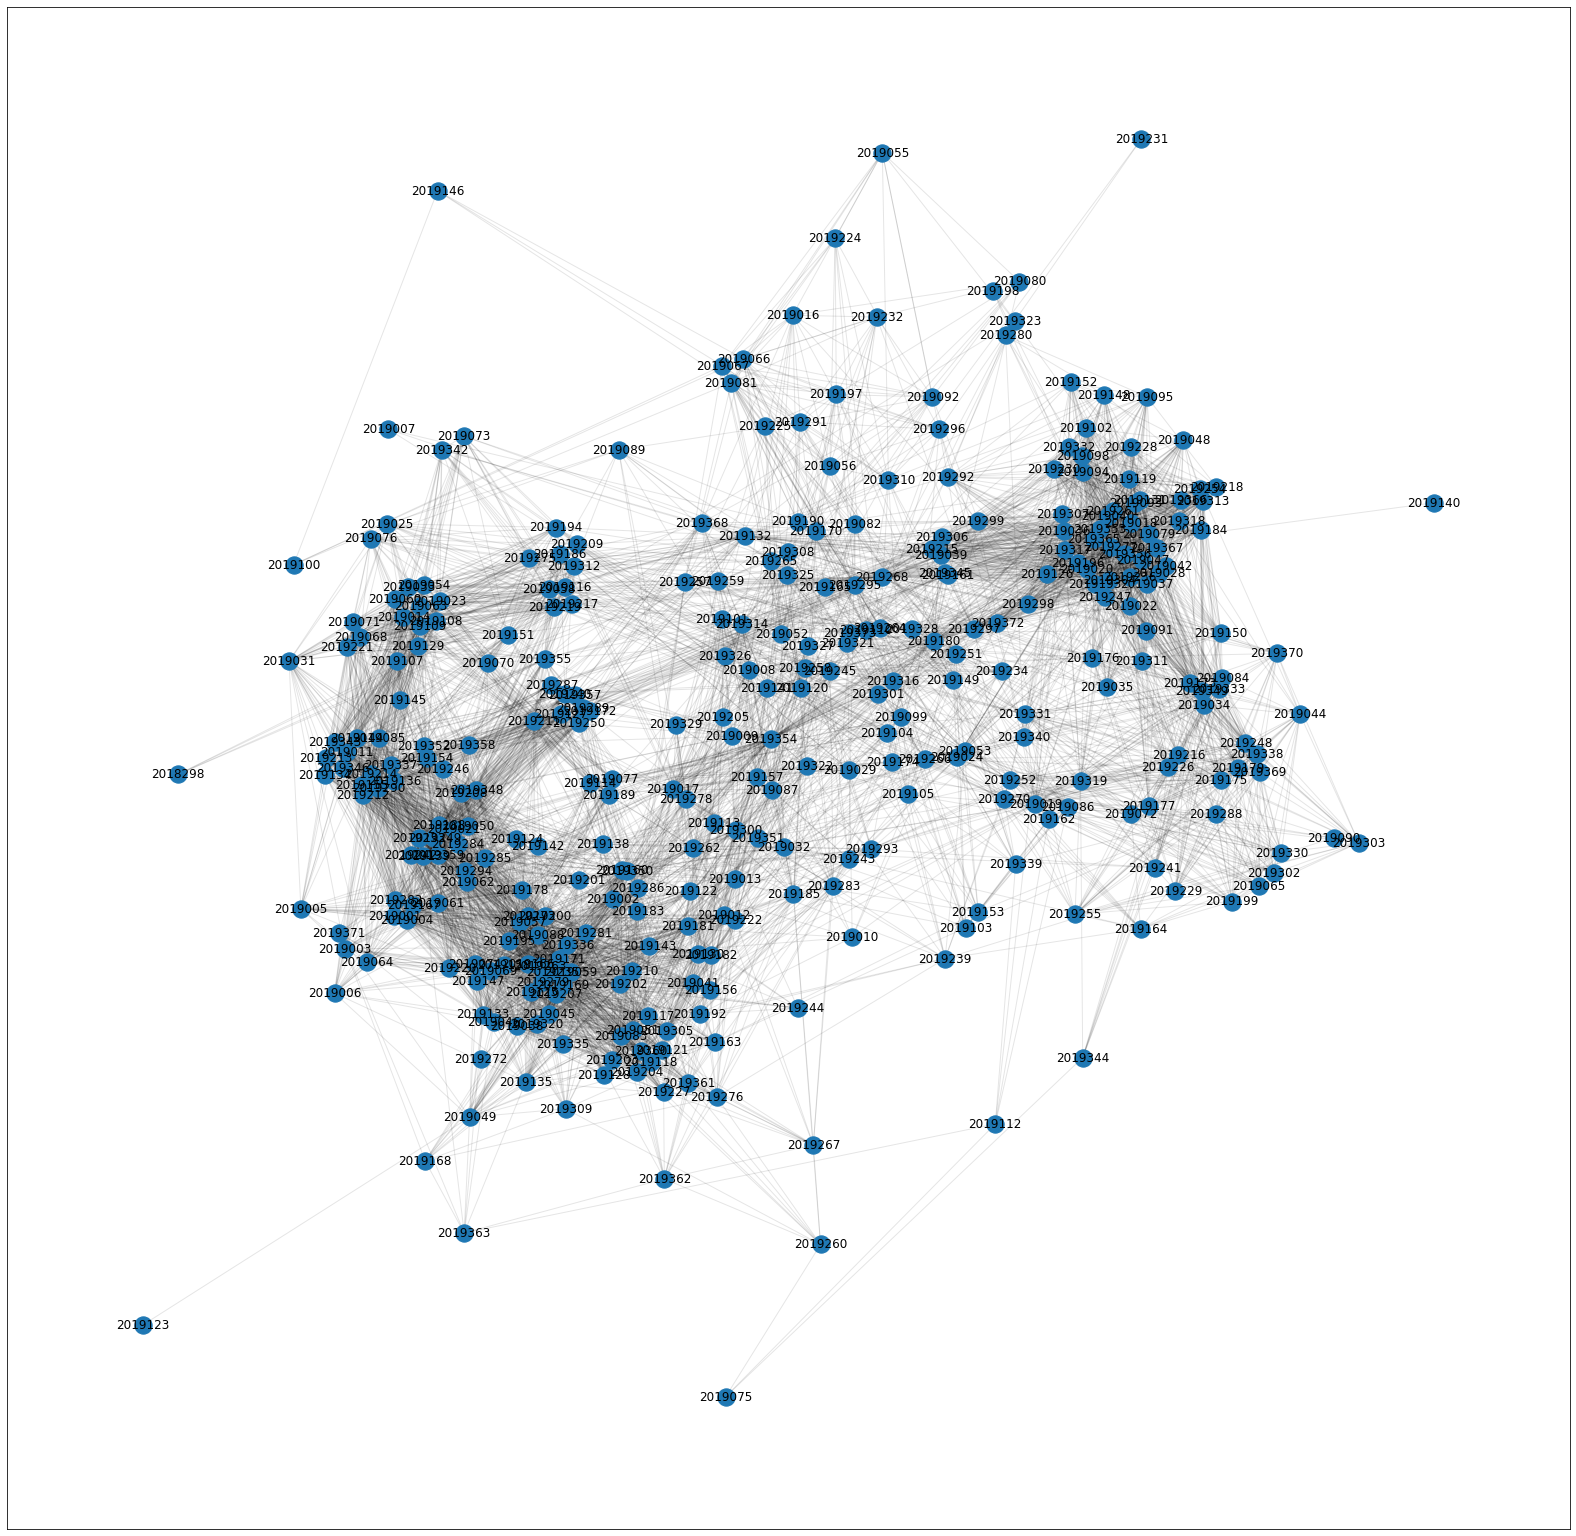

In [13]:
plt.rcParams['figure.figsize'] = [28,28]

# Find the largest connected component for visulaization
Gcc = sorted(nx.connected_components(G0), key=len, reverse=True)
print('no of connected components', len(Gcc))

G0s = G0.subgraph(Gcc[0])

pos = nx.spring_layout(G0s, k=0.2, iterations=20)
nx.draw_networkx_edges(G0s, pos=pos, alpha=0.1)
nx.draw_networkx_nodes(G0s, pos=pos)
nx.draw_networkx_labels(G0s, pos=pos, labels={ k : str(v) for k, v in zip(G0s.nodes(), G0s.nodes()) })


plt.show()

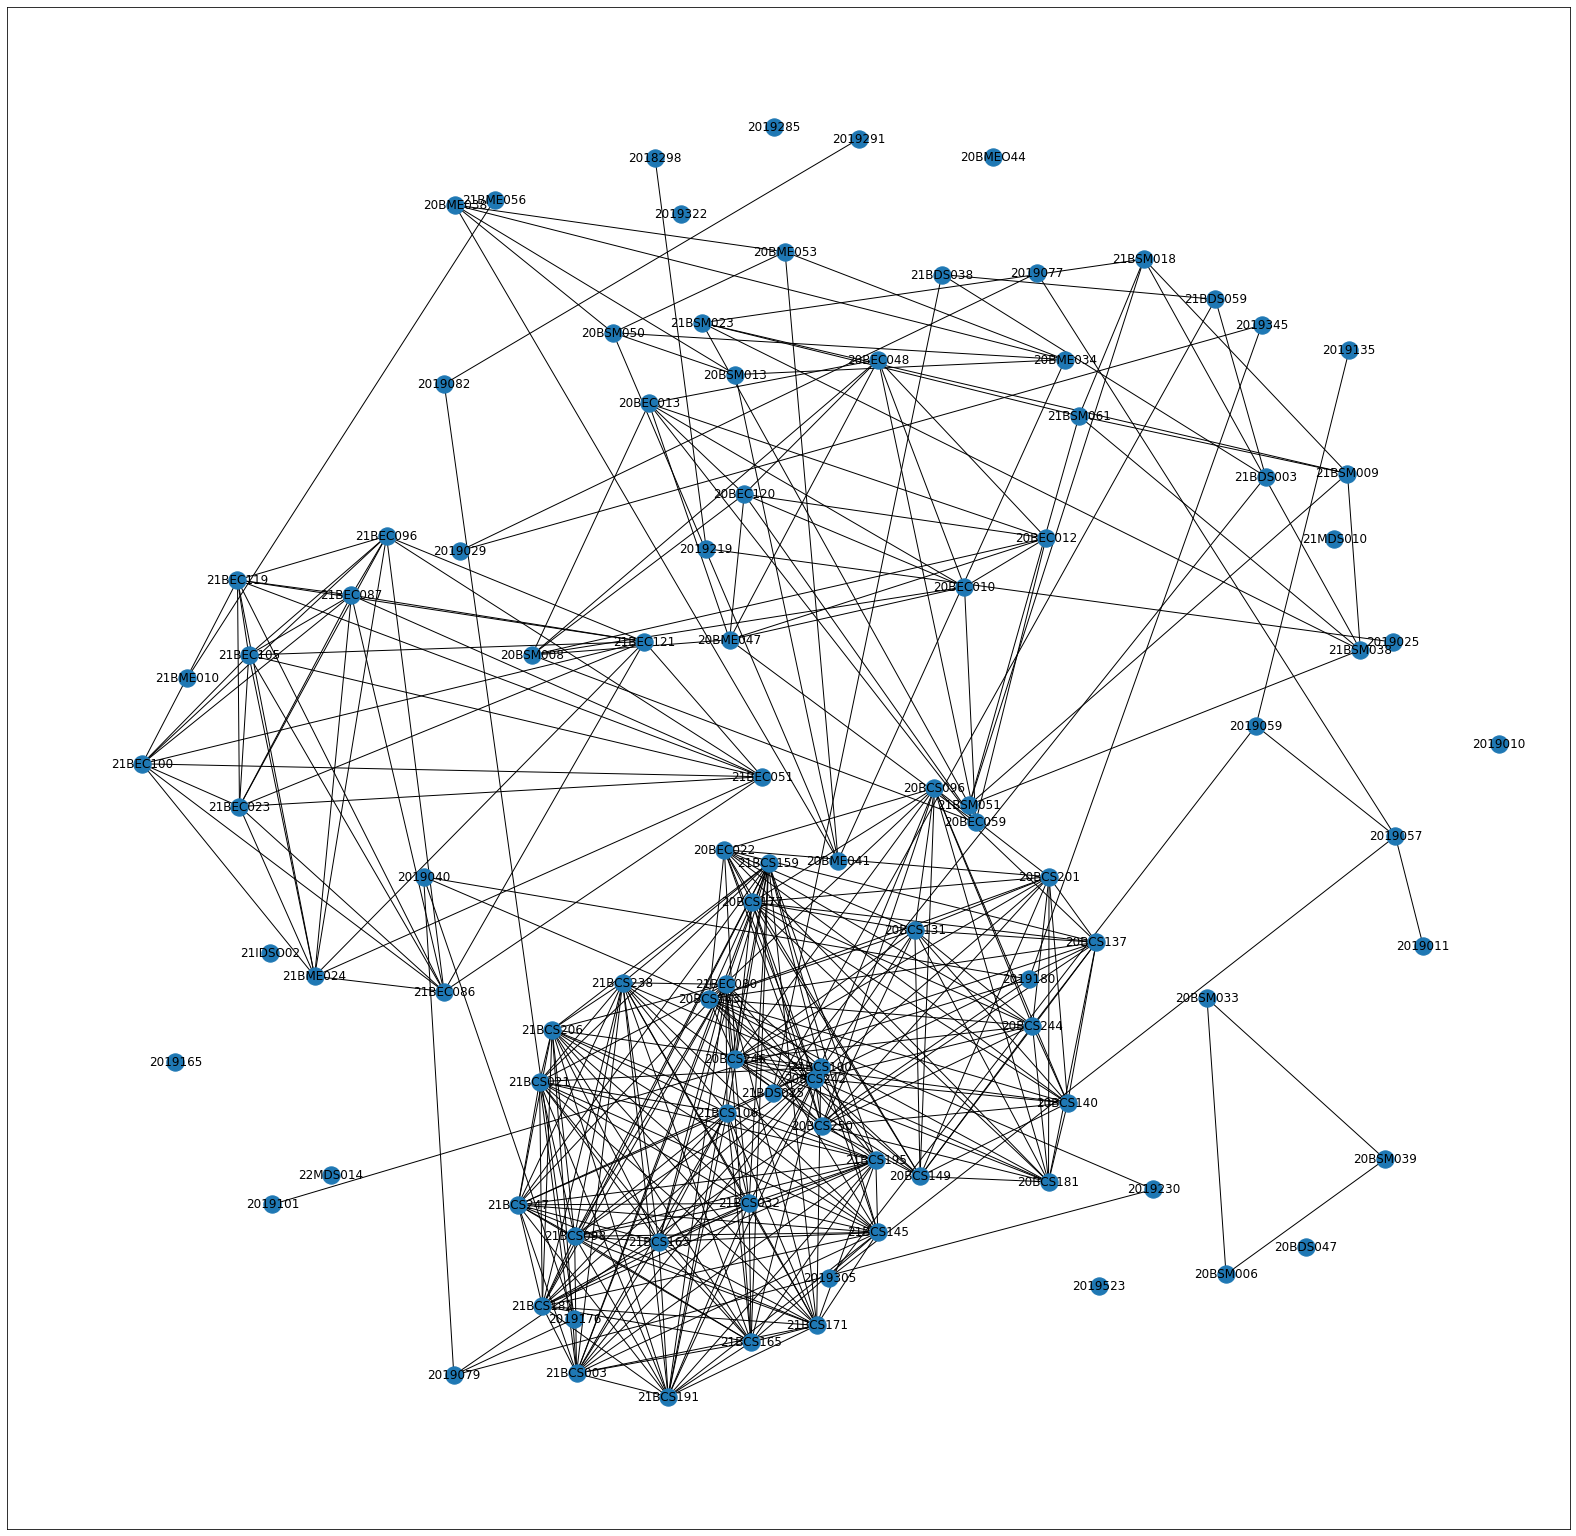

In [14]:
# Randomly selected 100 students

slg = list(G0.nodes())
random.shuffle(slg)

Gs = G0.subgraph(slg[:100])

plt.rcParams['figure.figsize'] = [28,28]
pos = nx.spring_layout(Gs, k=0.5, iterations=20) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(Gs, pos, with_labels=True)

plt.show()

## Community detection using Leiden's algo

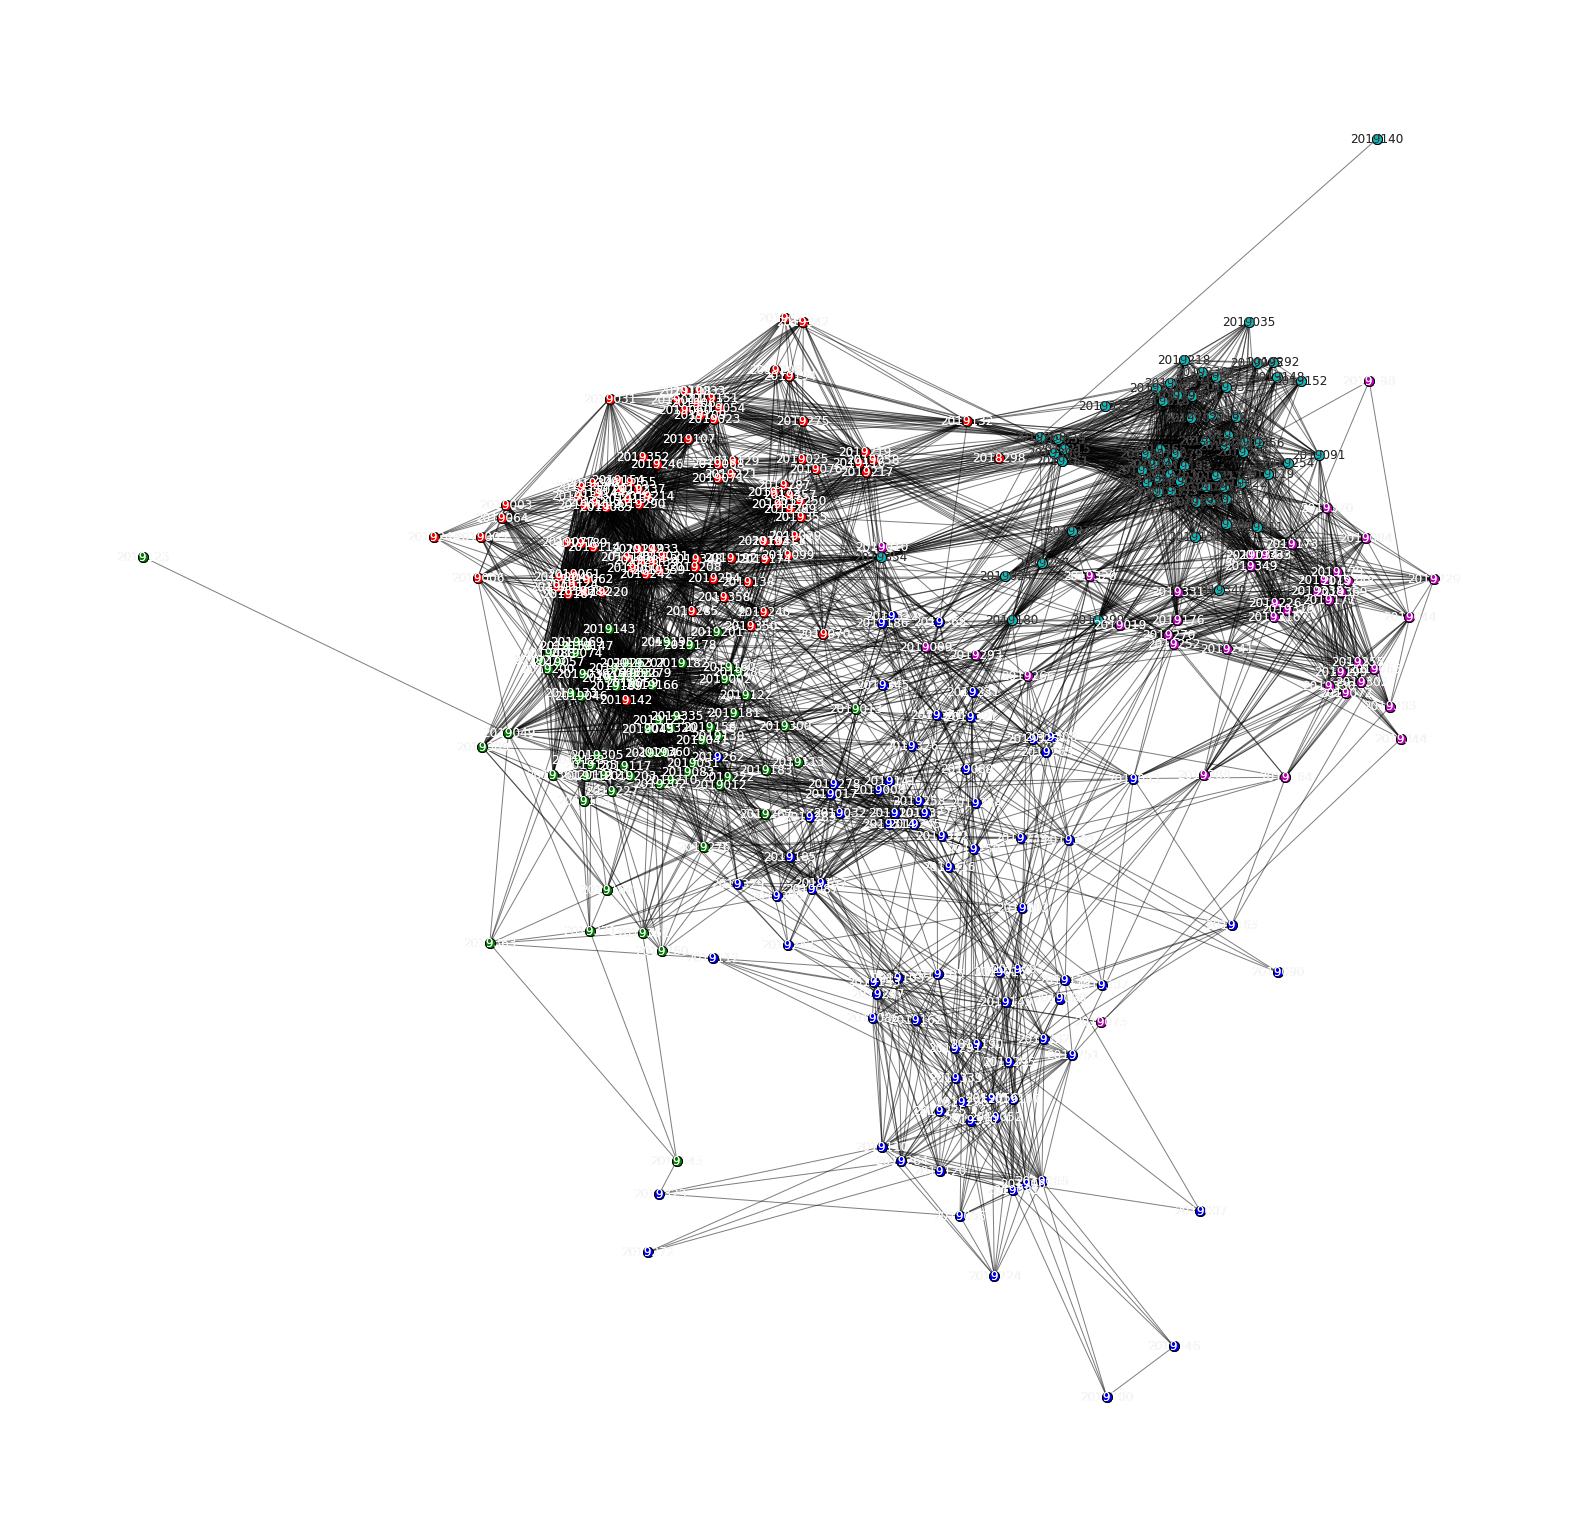

In [17]:
# we will apply it on Largest connected component for visualization

coms = algorithms.leiden(G0s)
pos = nx.spring_layout(G0s, k=0.5, iterations=100)
viz.plot_network_clusters(G0s, coms, pos, node_size=100, figsize=(28, 28), plot_labels=True)

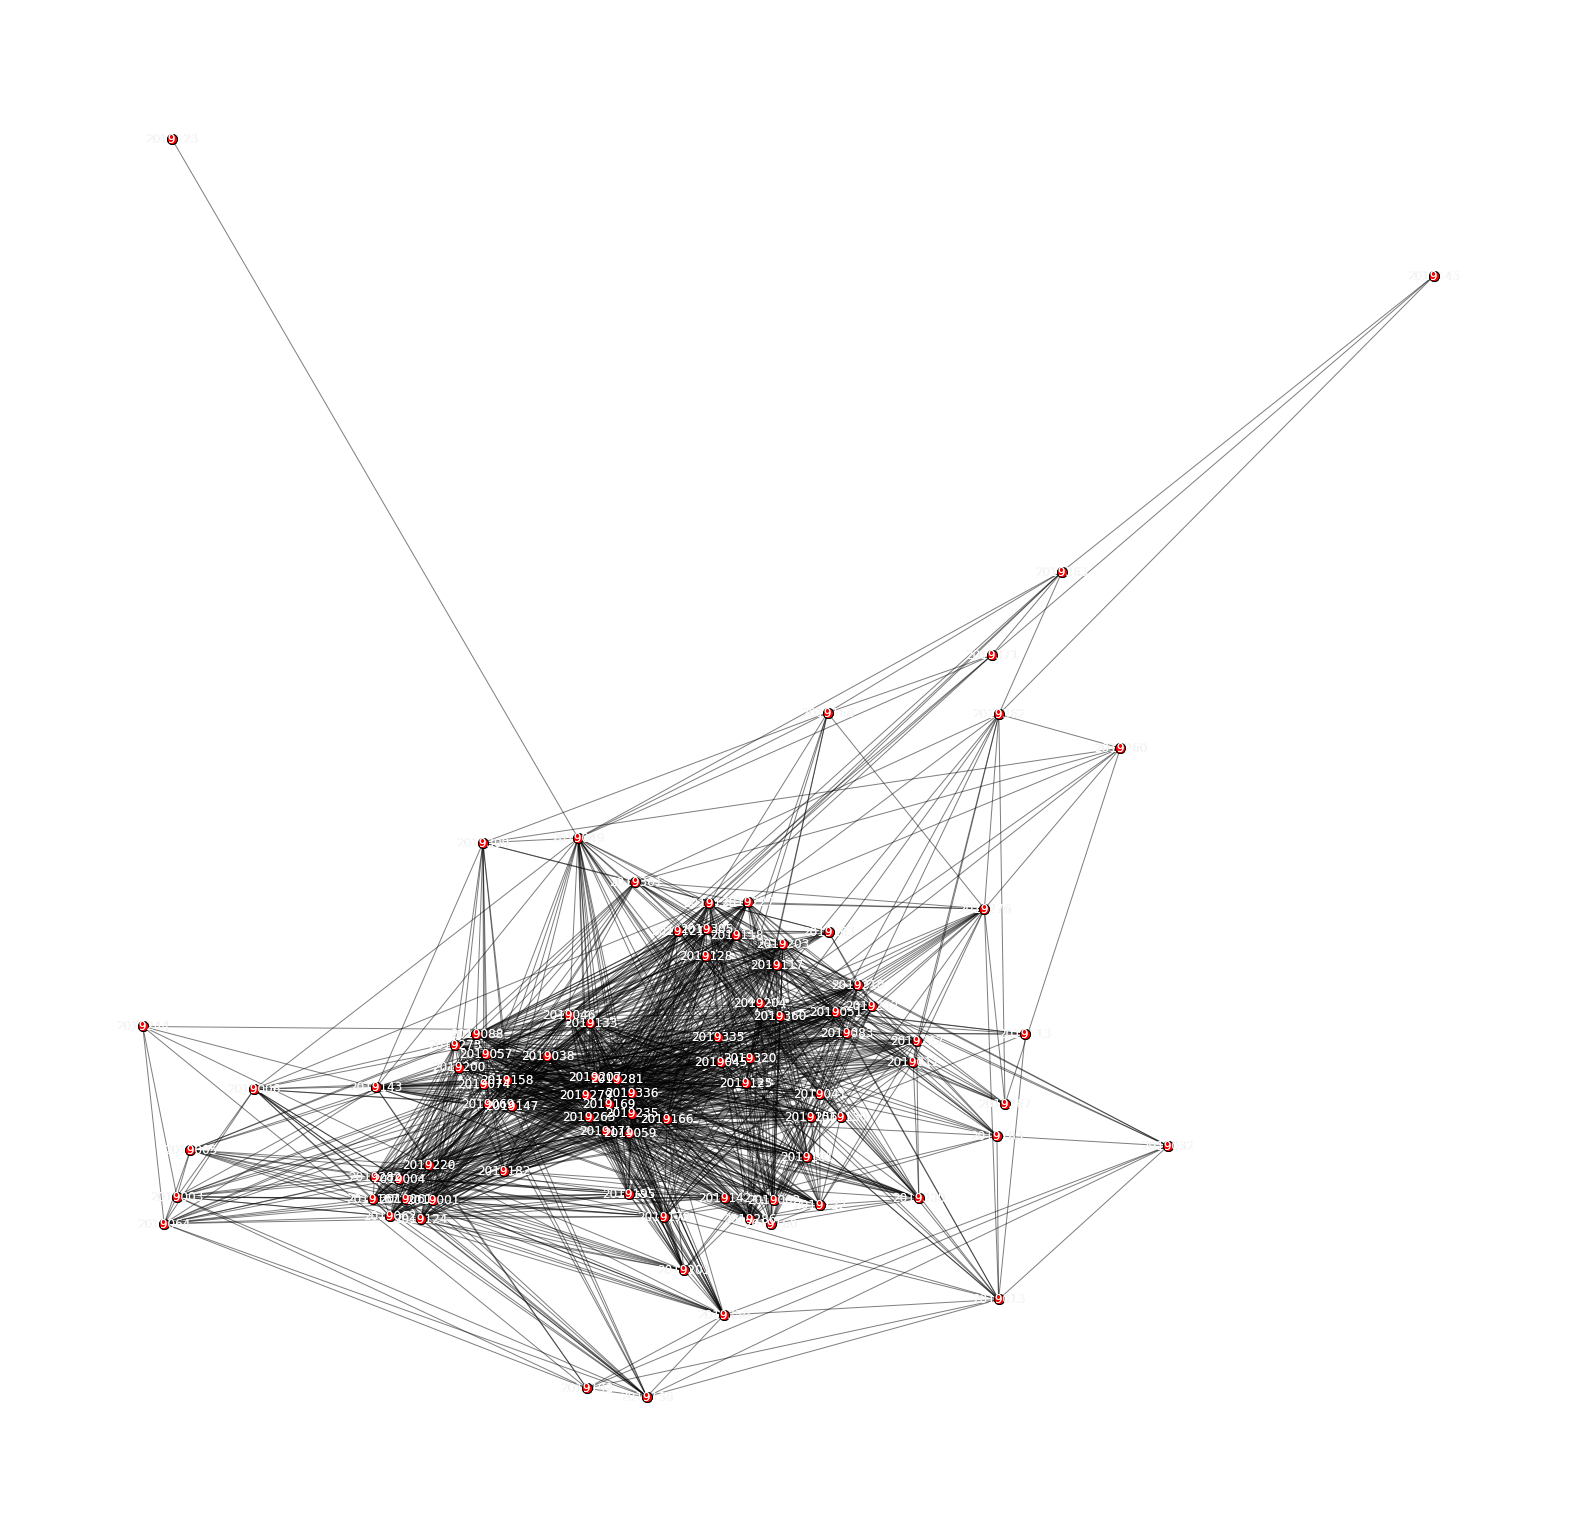

In [15]:
# Plotting the largest coomunity

pos = nx.spring_layout(G0s, k=0.2, iterations=200)
viz.plot_network_clusters(G0s, coms, pos, node_size=100, figsize=(28, 28), plot_labels=True, top_k=1)

## Running Leiden on whole graph

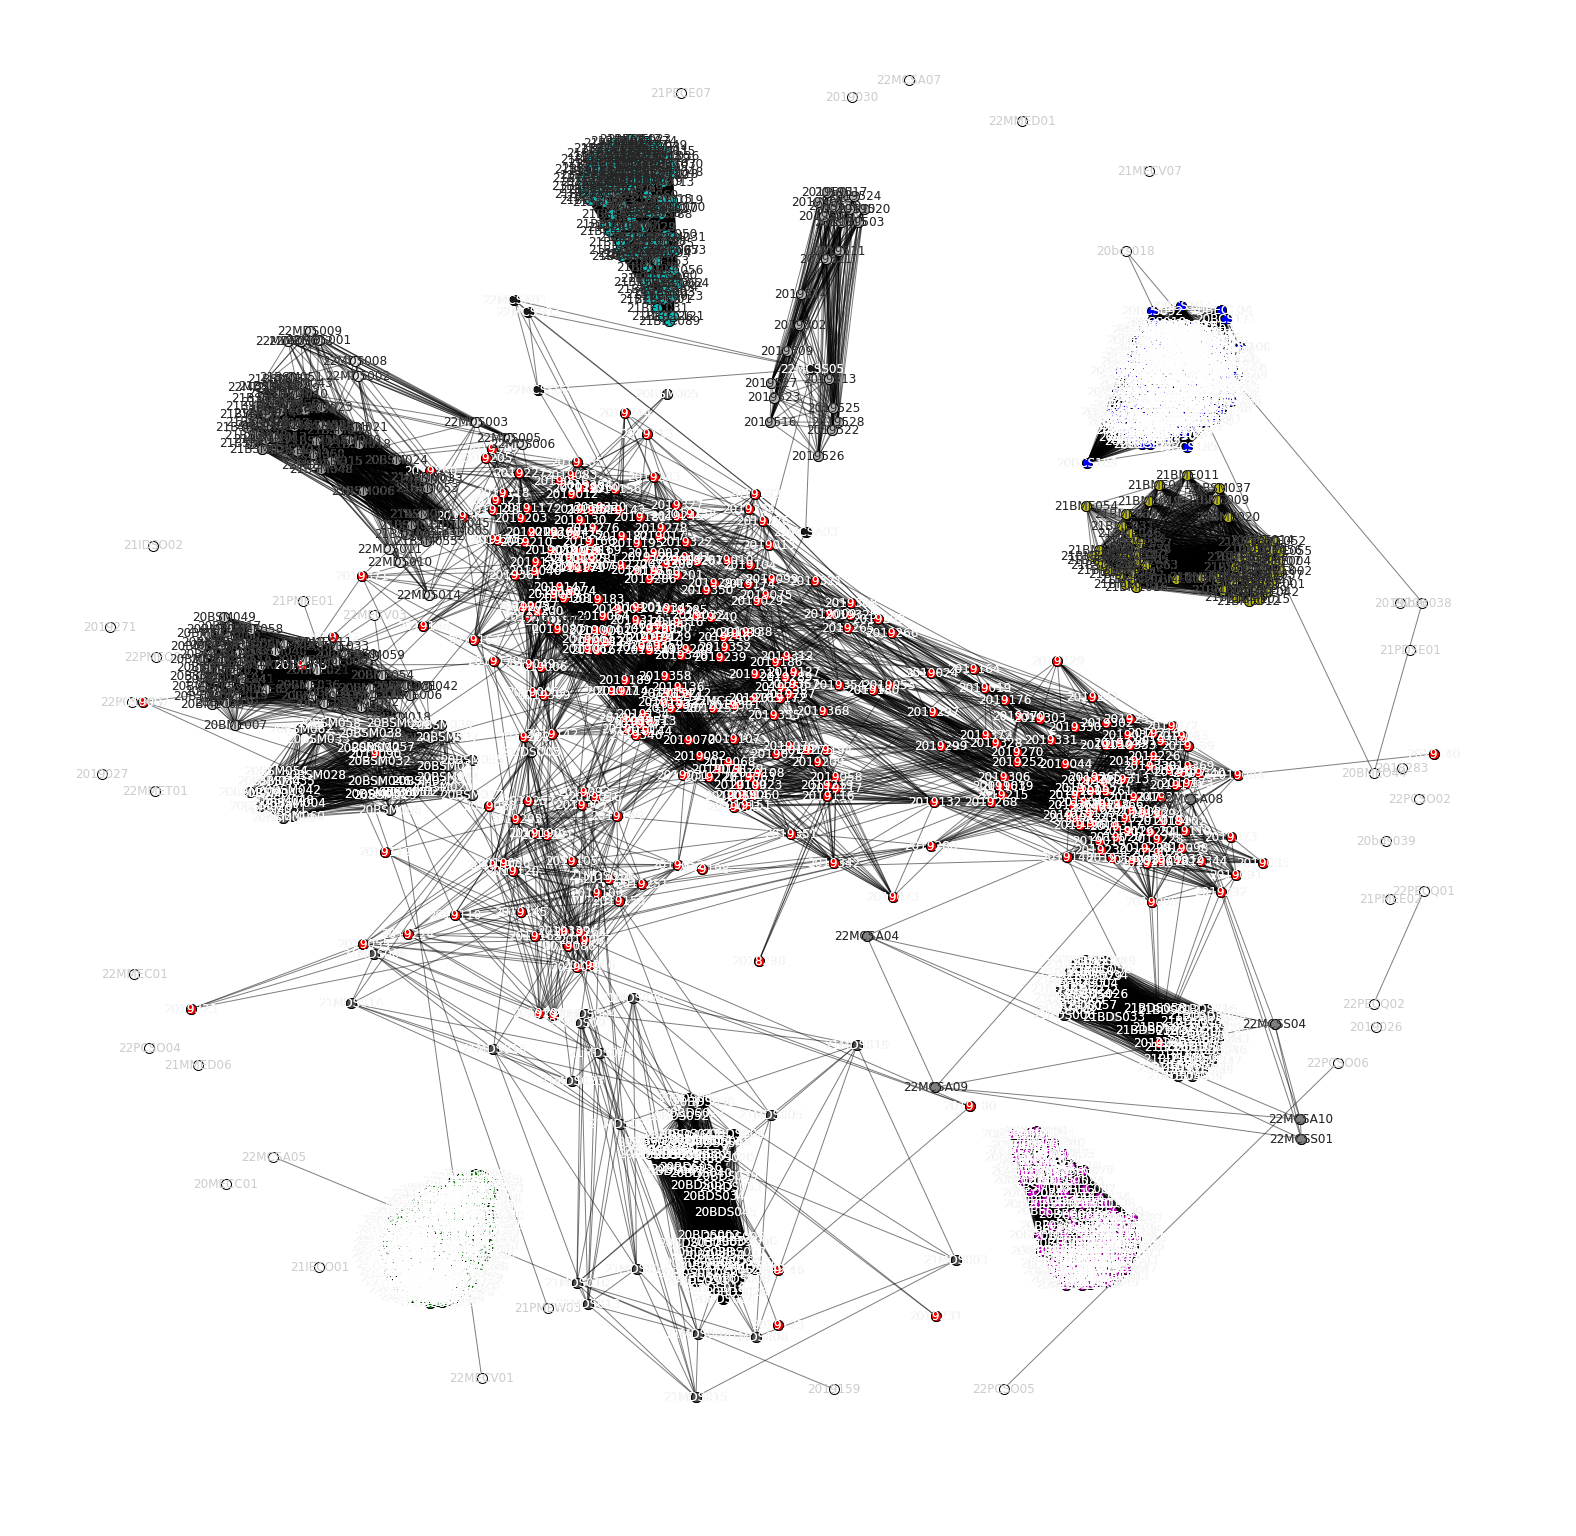

In [97]:
coms = algorithms.leiden(G0)

pos = nx.spring_layout(G0, k=0.5, iterations=100)
viz.plot_network_clusters(G0, coms, pos, node_size=100, figsize=(28, 28), plot_labels=True)

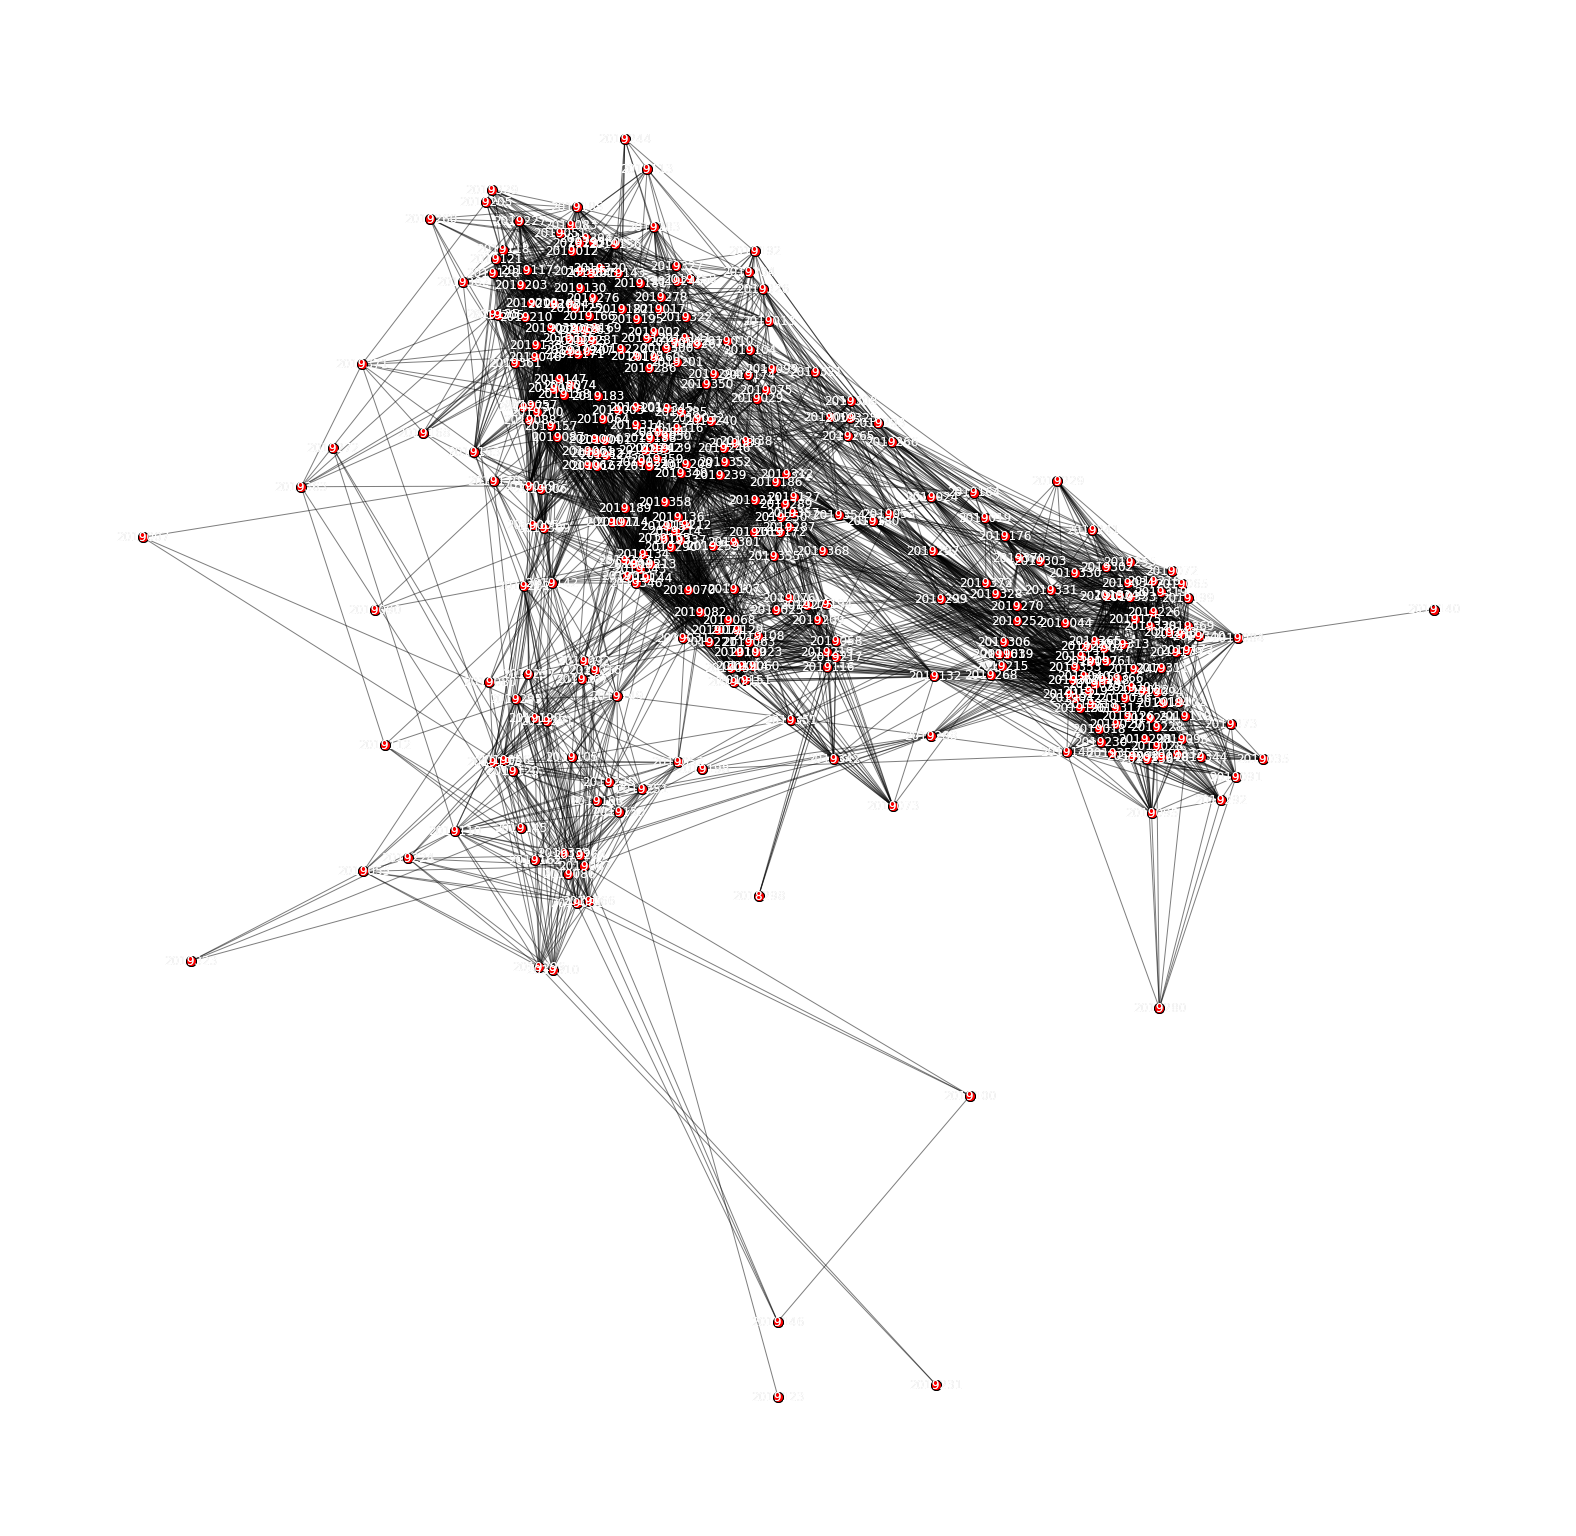

In [98]:
viz.plot_network_clusters(G0, coms, pos, node_size=100, figsize=(28, 28), plot_labels=True, top_k=1)

## Devisive Leiden Algorithm

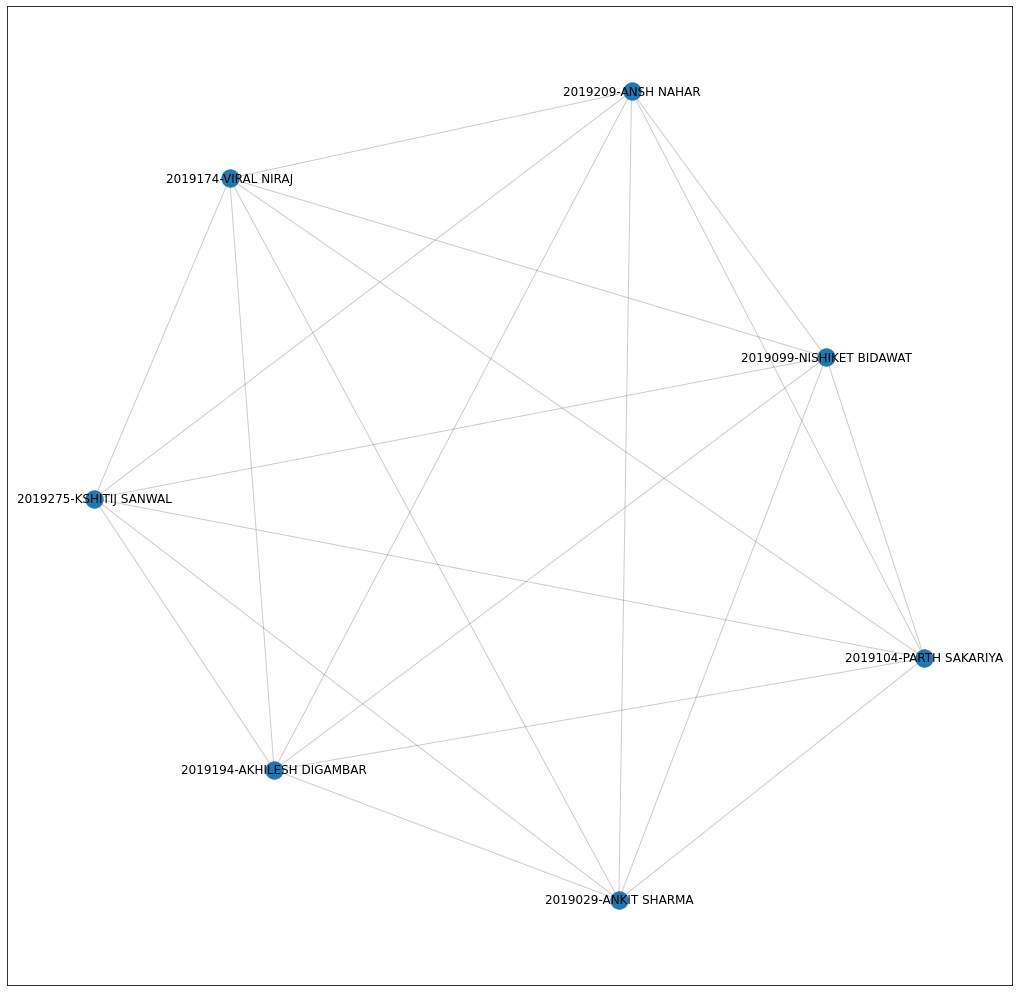

In [24]:
target_roll = '2019029'
def plt_community_of(target_roll, G, coms, neighbour_count=None):
    i = 0
    prev_neigh_count = 0
    while i<len(coms.communities):
        c = coms.communities[i]
        if target_roll in c:
            communitySG = G.subgraph(c)
            if prev_neigh_count == communitySG.number_of_nodes():
                print('cannot reduce community to', neighbour_count, 'nodes')
                break
            prev_neigh_count = communitySG.number_of_nodes()
            if neighbour_count is not None and neighbour_count < communitySG.number_of_nodes():
                coms = algorithms.leiden(communitySG)
                i = 0
            else:
                break
        else:
            i+=1
    else:
        print('cannot find target roll', target_roll)
        return
    
    pos = nx.spring_layout(communitySG, k=0.2, iterations=20)
    
    plt.rcParams['figure.figsize'] = [18,18]
    nx.draw_networkx_edges(communitySG, pos=pos, alpha=0.2)
    nx.draw_networkx_nodes(communitySG, pos=pos)
    nx.draw_networkx_labels(communitySG, pos=pos, labels={ k : str(v)+'-'+student_data[str(v)]['name'] for k, v in zip(communitySG.nodes(), communitySG.nodes()) })
    plt.show()


coms = algorithms.leiden(G0)
plt_community_of(target_roll, G0, coms, 10)